In [3]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import shutil

# Paths to your dataset
dataset_path = '/home/batch25/Desktop/initial data'
train_path = '/home/batch25/Desktop/train_data2'
val_path = '/home/batch25/Desktop/val_data2'
test_path = '/home/batch25/Desktop/test_data2'

# Function to split dataset into train, validation, and test sets
def split_dataset(dataset_path, train_path, val_path, test_path, train_split=0.8, val_split=0.1, test_split=0.1):
    if os.path.exists(train_path): shutil.rmtree(train_path)
    if os.path.exists(val_path): shutil.rmtree(val_path)
    if os.path.exists(test_path): shutil.rmtree(test_path)

    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            images = [os.path.join(class_path, img) for img in images]
            train, temp = train_test_split(images, test_size=(1 - train_split))
            val, test = train_test_split(temp, test_size=test_split / (val_split + test_split))

            # Create class subdirectories
            os.makedirs(os.path.join(train_path, class_folder), exist_ok=True)
            os.makedirs(os.path.join(val_path, class_folder), exist_ok=True)
            os.makedirs(os.path.join(test_path, class_folder), exist_ok=True)

            # Move files
            for img in train:
                shutil.copy(img, os.path.join(train_path, class_folder))
            for img in val:
                shutil.copy(img, os.path.join(val_path, class_folder))
            for img in test:
                shutil.copy(img, os.path.join(test_path, class_folder))

# Split the dataset
split_dataset(dataset_path, train_path, val_path, test_path)

# Load the InceptionV3 base model (GoogLeNet), excluding the top fully connected layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model initially
base_model.trainable = False

# Build the custom model
model = Sequential([
    base_model,                      # Pre-trained InceptionV3 base model
    GlobalAveragePooling2D(),        # Global average pooling to flatten features
    Dense(256, activation='relu'),   # Dense layer with 256 units
    BatchNormalization(),            # Batch normalization for stability
    Dropout(0.5),                    # Dropout to prevent overfitting
    Dense(128, activation='relu'),   # Dense layer with 128 units
    Dropout(0.3),                    # Dropout for regularization
    Dense(5, activation='softmax')   # Output layer with 5 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Callbacks for early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# Train the model with frozen layers
initial_history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Save the model
model.save("googlenet_hasta_recognition_model.h5")


W0000 00:00:1732028380.894146  222897 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Found 218 images belonging to 5 classes.
Found 26 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


/home/batch25/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.1899 - loss: 2.4657 - val_accuracy: 0.2308 - val_loss: 1.8785 - learning_rate: 0.0010
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.3161 - loss: 1.7789 - val_accuracy: 0.2308 - val_loss: 2.0960 - learning_rate: 0.0010
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.3986 - loss: 1.5615 - val_accuracy: 0.2692 - val_loss: 2.0760 - learning_rate: 0.0010
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.3865 - loss: 1.5838 - val_accuracy: 0.3077 - val_loss: 2.1332 - learning_rate: 0.0010
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.4593 - loss: 1.4208 - val_accuracy: 0.3077 - val_loss: 1.8632 - learning_rate: 5.0000e-04
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.4862 - loss: 1.3990 - val_accuracy: 0.3846 - val_loss: 1.6411 - learning_rate: 5.0000e-04
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.4431 - loss: 1.3668 - val_accuracy: 0.4231

Test Loss: 0.9404824376106262
Test Accuracy: 0.5666666626930237


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Initialize ImageDataGenerator for the test set (rescale the pixel values)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load the test dataset
test_generator = val_datagen.flow_from_directory(
    '/home/batch25/Desktop/test_data2',  # Path to your test data
    target_size=(128, 128),              # Ensure this matches your model input size
    batch_size=32,
    class_mode='categorical',
    shuffle=False                        # Do not shuffle to keep predictions aligned with true labels
)

# Get true labels from the test data generator
true_labels = test_generator.classes

# Predict on the test set
predictions = model.predict(test_generator)

# Convert predictions to class indices
predicted_labels = np.argmax(predictions, axis=1)

# Generate a classification report
class_names = list(test_generator.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")


Found 30 images belonging to 5 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

           1       0.67      1.00      0.80         6
          10       0.00      0.00      0.00         6
          12       0.50      0.67      0.57         6
          20       0.67      0.67      0.67         6
           5       0.60      0.50      0.55         6

    accuracy                           0.57        30
   macro avg       0.49      0.57      0.52        30
weighted avg       0.49      0.57      0.52        30

Test Accuracy: 0.5667


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import numpy as np

# Paths to your datasets (update these paths accordingly)
train_data_path = '/home/batch25/Desktop/train_data2'
val_data_path = '/home/batch25/Desktop/val_data2'
test_data_path = '/home/batch25/Desktop/test_data2'

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(5, activation='softmax')  # Output layer with 5 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_acc}")

# Predict on the test data
test_predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
test_predictions = np.argmax(test_predictions, axis=1)

# Get the true labels
true_labels = test_generator.classes

# Print classification metrics
print(classification_report(true_labels, test_predictions, target_names=test_generator.class_indices.keys()))



Found 218 images belonging to 5 classes.
Found 26 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.2182 - loss: 9.7895 - val_accuracy: 0.2308 - val_loss: 4.8356
Epoch 2/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4062 - loss: 5.8180

/home/batch25/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 592ms/step - accuracy: 0.4062 - loss: 5.8180 - val_accuracy: 0.2692 - val_loss: 6.2313
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.4068 - loss: 4.7569 - val_accuracy: 0.3846 - val_loss: 2.7427
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 573ms/step - accuracy: 0.3438 - loss: 3.6984 - val_accuracy: 0.3846 - val_loss: 2.3137
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.4293 - loss: 1.7752 - val_accuracy: 0.3846 - val_loss: 1.7935
Epoch 6/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2692 - loss: 1.8007

2024-11-19 21:29:27.647091: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 586ms/step - accuracy: 0.2692 - loss: 1.8007 - val_accuracy: 0.3846 - val_loss: 1.6833
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.4662 - loss: 1.2357 - val_accuracy: 0.4615 - val_loss: 1.3345
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 600ms/step - accuracy: 0.4688 - loss: 1.1646 - val_accuracy: 0.4615 - val_loss: 1.3205
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.4738 - loss: 1.1968 - val_accuracy: 0.4615 - val_loss: 1.2404
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 576ms/step - accuracy: 0.5625 - loss: 0.9074 - val_accuracy: 0.5000 - val_loss: 1.2279
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.5422 - loss: 1.0470 - val_accuracy: 0.4231 - val_loss: 1.2398
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 583ms/step - accuracy: 0.7188 - loss: 0.8731 - val_accuracy: 0.5000 - val_loss: 1.2320
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.6515 - loss: 0.9504 - val_accuracy: 0.4615 - val_loss: 1.2367
Epoch 1

2024-11-19 21:36:41.167040: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 597ms/step - accuracy: 0.7500 - loss: 0.6627 - val_accuracy: 0.6154 - val_loss: 0.8394
Epoch 39/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.6897 - loss: 0.8131 - val_accuracy: 0.5385 - val_loss: 0.8369
Epoch 40/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 577ms/step - accuracy: 0.6250 - loss: 0.8273 - val_accuracy: 0.5000 - val_loss: 0.9123
Epoch 41/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.6321 - loss: 0.8825 - val_accuracy: 0.6154 - val_loss: 0.9408
Epoch 42/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 594ms/step - accuracy: 0.7188 - loss: 0.6656 - val_accuracy: 0.6154 - val_loss: 0.9161
Epoch 43/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.7205 - loss: 0.7442 - val_accuracy: 0.5769 - val_loss: 0.9571
Epoch 44/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 588ms/step - accuracy: 0.7500 - loss: 0.6095 - val_accuracy: 0.6154 - val_loss: 0.9502
Epoch 45/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.7368 - loss: 0.6854 - val_accuracy: 0.5385 - val_loss: 1.0028
Epoc

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Step 1: Set up data augmentation
train_data_path = '/home/batch25/Desktop/train_data2'
val_data_path = '/home/batch25/Desktop/val_data2'
test_data_path = '/home/batch25/Desktop/test_data2'

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
# Step 2: Load InceptionV3 and build the model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreeze the last few layers for fine-tuning
base_model.trainable = True
fine_tune_at = 100  # Unfreeze layers after this point
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Build the custom model on top of InceptionV3
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(5, activation='softmax')  # 5 classes as per your dataset
])

# Step 3: Compile the model with a low initial learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Step 4: Compute class weights to address class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))

# Step 5: Set up learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Step 6: Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=[lr_scheduler]
)

# Step 7: Evaluate the model


# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# Step 8: Calculate precision, recall, F1 score for the whole model
from sklearn.metrics import classification_report

# Get true labels and predictions
true_labels = test_generator.classes
predictions = np.argmax(model.predict(test_generator), axis=-1)

# Classification report
report = classification_report(true_labels, predictions, target_names=test_generator.class_indices)
print(report)


Found 218 images belonging to 5 classes.
Found 26 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


/home/batch25/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2024-11-19 21:27:19.298750: W tensorflow/core/framework/op_kernel.cc:1829] INVALID_ARGUMENT: TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.6591442 , 0.6749374 , 0.6706951 ],
         [0.66371846, 0.67940474, 0.67548317],
         [0.6645063 , 0.6801926 , 0.676271  ],
         ...,
         [0.68771964, 0.6955628 , 0.6837981 ],
         [0.6921863 , 0.70002943, 0.6882647 ],
         [0.7087425 , 0.7131948 , 0.7065163 ]],

        [[0.6696548 , 0.68895155, 0.6741987 ],
         [0.66199183, 0.6787342 , 0.6716444 ],
         [0.66182005, 0.6775063 , 0.67358476],
         ...,
         [0.6883113 , 0.6961544 , 0.6843897 ],
         [0.7061592 , 0.7119031 , 0.7032871 ],
         [0.7135745 , 0.7144795 , 0.713122  ]],

        [[0.6482417 , 0.6582724 , 0.6457785 ],
         [0.666122  , 0.68381566, 0.66876745],
         [0.66483945, 0.68253094, 0.67

InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.6591442 , 0.6749374 , 0.6706951 ],
         [0.66371846, 0.67940474, 0.67548317],
         [0.6645063 , 0.6801926 , 0.676271  ],
         ...,
         [0.68771964, 0.6955628 , 0.6837981 ],
         [0.6921863 , 0.70002943, 0.6882647 ],
         [0.7087425 , 0.7131948 , 0.7065163 ]],

        [[0.6696548 , 0.68895155, 0.6741987 ],
         [0.66199183, 0.6787342 , 0.6716444 ],
         [0.66182005, 0.6775063 , 0.67358476],
         ...,
         [0.6883113 , 0.6961544 , 0.6843897 ],
         [0.7061592 , 0.7119031 , 0.7032871 ],
         [0.7135745 , 0.7144795 , 0.713122  ]],

        [[0.6482417 , 0.6582724 , 0.6457785 ],
         [0.666122  , 0.68381566, 0.66876745],
         [0.66483945, 0.68253094, 0.6725936 ],
         ...,
         [0.7035758 , 0.7106114 , 0.700058  ],
         [0.7168738 , 0.7172604 , 0.71668047],
         [0.68946654, 0.69572884, 0.6863353 ]],

        ...,

        [[0.4241208 , 0.39666983, 0.36648002],
         [0.42744532, 0.39999434, 0.37645352],
         [0.44072625, 0.41327527, 0.38310826],
         ...,
         [0.61628085, 0.6297491 , 0.62582755],
         [0.6109359 , 0.6266222 , 0.62270063],
         [0.5964689 , 0.6121552 , 0.60823363]],

        [[0.42679948, 0.3993485 , 0.374516  ],
         [0.4381429 , 0.41069192, 0.38181657],
         [0.43068182, 0.40945858, 0.37601012],
         ...,
         [0.6071522 , 0.61499536, 0.6110738 ],
         [0.6134333 , 0.62500316, 0.6210816 ],
         [0.6166311 , 0.63231736, 0.6283958 ]],

        [[0.43555957, 0.40810856, 0.38052487],
         [0.43455684, 0.4113961 , 0.37859347],
         [0.4212739 , 0.4055876 , 0.3702935 ],
         ...,
         [0.605832  , 0.6136751 , 0.60975355],
         [0.606203  , 0.61404616, 0.6101246 ],
         [0.6105857 , 0.6202572 , 0.61633563]]],


       [[[0.6702271 , 0.674239  , 0.65463114],
         [0.6569136 , 0.66425383, 0.644646  ],
         [0.66620386, 0.67122155, 0.6516137 ],
         ...,
         [0.6096904 , 0.61753356, 0.6039216 ],
         [0.61347497, 0.6213181 , 0.6039216 ],
         [0.6180461 , 0.62588924, 0.6094278 ]],

        [[0.6612392 , 0.6670306 , 0.64742273],
         [0.66475403, 0.6701342 , 0.65052634],
         [0.6583634 , 0.66534114, 0.6457333 ],
         ...,
         [0.6170946 , 0.6249377 , 0.6072075 ],
         [0.6227714 , 0.6306145 , 0.62045336],
         [0.6257891 , 0.63363224, 0.62904596]],

        [[0.6514386 , 0.6591901 , 0.6395823 ],
         [0.66808045, 0.6725036 , 0.65289575],
         [0.659281  , 0.66602945, 0.6464216 ],
         ...,
         [0.6273751 , 0.63521826, 0.63126636],
         [0.6179138 , 0.6257569 , 0.6180205 ],
         [0.60845244, 0.6162956 , 0.60477453]],

        ...,

        [[0.55871516, 0.5482166 , 0.5347226 ],
         [0.54357696, 0.5387552 , 0.523369  ],
         [0.5475453 , 0.54362375, 0.5279375 ],
         ...,
         [0.5857413 , 0.58680785, 0.5714824 ],
         [0.57100755, 0.56922644, 0.56102395],
         [0.5568628 , 0.54901963, 0.5529412 ]],

        [[0.5462765 , 0.54235494, 0.52666867],
         [0.5538456 , 0.549924  , 0.53423774],
         [0.5477589 , 0.5438373 , 0.52815104],
         ...,
         [0.5877014 , 0.5848477 , 0.5754027 ],
         [0.584373  , 0.5881761 , 0.568746  ],
         [0.5614298 , 0.555544  , 0.55555093]],

        [[0.5502965 , 0.5463749 , 0.53068864],
         [0.53515834, 0.53123677, 0.5155505 ],
         [0.52754146, 0.52225244, 0.5058824 ],
         ...,
         [0.5768261 , 0.57433075, 0.5664876 ],
         [0.58633316, 0.586216  , 0.57266617],
         [0.57515067, 0.5751451 , 0.56339145]]],


       [[[0.7568628 , 0.79215693, 0.78823537],
         [0.7568628 , 0.79215693, 0.78823537],
         [0.7568628 , 0.79215693, 0.78823537],
         ...,
         [0.6784314 , 0.6784314 , 0.67058825],
         [0.6784314 , 0.6784314 , 0.67058825],
         [0.6784314 , 0.6784314 , 0.67058825]],

        [[0.7568628 , 0.79215693, 0.78823537],
         [0.7568628 , 0.79215693, 0.78823537],
         [0.7568628 , 0.79215693, 0.78823537],
         ...,
         [0.6784314 , 0.6784314 , 0.67058825],
         [0.6784314 , 0.6784314 , 0.67058825],
         [0.6784314 , 0.6784314 , 0.67058825]],

        [[0.7568628 , 0.79215693, 0.78823537],
         [0.7568628 , 0.79215693, 0.78823537],
         [0.7568628 , 0.79215693, 0.78823537],
         ...,
         [0.6784314 , 0.6784314 , 0.67058825],
         [0.6784314 , 0.6784314 , 0.67058825],
         [0.6784314 , 0.6784314 , 0.67058825]],

        ...,

        [[0.2627451 , 0.24313727, 0.227451  ],
         [0.2624982 , 0.24289036, 0.22720408],
         [0.25764015, 0.23803233, 0.22234605],
         ...,
         [0.606281  , 0.61411256, 0.6071493 ],
         [0.5752385 , 0.5752385 , 0.5673954 ],
         [0.5886889 , 0.5886889 , 0.58098215]],

        [[0.2454188 , 0.22581096, 0.21012469],
         [0.24056077, 0.22095291, 0.20526664],
         [0.22809128, 0.20965442, 0.19338267],
         ...,
         [0.5930967 , 0.5966677 , 0.5941863 ],
         [0.5775832 , 0.577598  , 0.57565373],
         [0.5693904 , 0.5693904 , 0.5679485 ]],

        [[0.1893903 , 0.17502724, 0.15671857],
         [0.17400652, 0.16126281, 0.14214447],
         [0.16054372, 0.1510202 , 0.13269301],
         ...,
         [0.57923335, 0.57923335, 0.5741497 ],
         [0.5798973 , 0.5798973 , 0.57897556],
         [0.5688231 , 0.5688231 , 0.561959  ]]],


       ...,


       [[[0.64720964, 0.6390931 , 0.61717576],
         [0.6291522 , 0.60873026, 0.5667028 ],
         [0.54421103, 0.50418735, 0.446914  ],
         ...,
         [0.6616009 , 0.6616009 , 0.669444  ],
         [0.6379089 , 0.6379089 , 0.645752  ],
         [0.6442394 , 0.6420949 , 0.65637153]],

        [[0.604105  , 0.604105  , 0.61194813],
         [0.6358349 , 0.6298511 , 0.6157539 ],
         [0.6568783 , 0.6428547 , 0.60580367],
         ...,
         [0.64469045, 0.64469045, 0.6525336 ],
         [0.63915324, 0.6378564 , 0.6495899 ],
         [0.65355515, 0.6499703 , 0.668568  ]],

        [[0.6069939 , 0.6069939 , 0.61483705],
         [0.60481596, 0.60481596, 0.6126591 ],
         [0.62446004, 0.6206091 , 0.614332  ],
         ...,
         [0.63406706, 0.63361794, 0.6428084 ],
         [0.65183604, 0.6484255 , 0.6665004 ],
         [0.64509994, 0.64362884, 0.65588516]],

        ...,

        [[0.6468055 , 0.6507271 , 0.65857023],
         [0.63495946, 0.638881  , 0.64672416],
         [0.6334374 , 0.63735896, 0.6452021 ],
         ...,
         [0.6115359 , 0.61534315, 0.6231863 ],
         [0.60718   , 0.60880923, 0.61665237],
         [0.6061168 , 0.6061168 , 0.6139599 ]],

        [[0.63835025, 0.6422718 , 0.65011495],
         [0.6325897 , 0.63651127, 0.6443544 ],
         [0.63606524, 0.6399868 , 0.64782995],
         ...,
         [0.6200883 , 0.62400985, 0.631853  ],
         [0.61355436, 0.6174759 , 0.62531906],
         [0.60860187, 0.61094195, 0.6187851 ]],

        [[0.63174194, 0.6356635 , 0.64350665],
         [0.6347035 , 0.6386251 , 0.6464682 ],
         [0.64240664, 0.6463282 , 0.65417135],
         ...,
         [0.6165621 , 0.6204837 , 0.62832683],
         [0.622221  , 0.62614256, 0.63398576],
         [0.6156871 , 0.61960864, 0.6274518 ]]],


       [[[0.64773804, 0.6937124 , 0.7023661 ],
         [0.6805998 , 0.7113957 , 0.70936567],
         [0.6923581 , 0.708786  , 0.69526166],
         ...,
         [0.5351249 , 0.53904647, 0.55865437],
         [0.5265592 , 0.53048074, 0.5500886 ],
         [0.5094734 , 0.51339495, 0.5330028 ]],

        [[0.6354102 , 0.6921714 , 0.70390713],
         [0.662108  , 0.7006088 , 0.7047427 ],
         [0.69659096, 0.7207238 , 0.71336347],
         ...,
         [0.50631404, 0.5102356 , 0.52984345],
         [0.49027678, 0.49419835, 0.51380616],
         [0.49170056, 0.49562213, 0.51523   ]],

        [[0.6230823 , 0.69063044, 0.7054481 ],
         [0.64607096, 0.693504  , 0.70257455],
         [0.67809916, 0.7099369 , 0.70874053],
         ...,
         [0.49196386, 0.49588543, 0.5154933 ],
         [0.49338767, 0.49730924, 0.51691705],
         [0.5017496 , 0.50567114, 0.525279  ]],

        ...,

        [[0.44557983, 0.42989355, 0.39459944],
         [0.45309615, 0.43740988, 0.40211576],
         [0.4540029 , 0.4365034 , 0.4018137 ],
         ...,
         [0.5916848 , 0.5917206 , 0.622986  ],
         [0.5972675 , 0.5990413 , 0.6250924 ],
         [0.612251  , 0.6160147 , 0.63609606]],

        [[0.45575145, 0.44006518, 0.40477106],
         [0.4693951 , 0.45370883, 0.4184147 ],
         [0.45354035, 0.43785408, 0.40255997],
         ...,
         [0.59961164, 0.5996894 , 0.6308287 ],
         [0.61776626, 0.6193479 , 0.643849  ],
         [0.6070473 , 0.6086046 , 0.6317589 ]],

        [[0.45285028, 0.437164  , 0.4018699 ],
         [0.4740296 , 0.45834333, 0.4230492 ],
         [0.47326672, 0.45758045, 0.42228633],
         ...,
         [0.61106807, 0.6102909 , 0.63977414],
         [0.6275784 , 0.62379116, 0.65506595],
         [0.59622025, 0.5938252 , 0.6246469 ]]],


       [[[0.5546962 , 0.5546962 , 0.54685307],
         [0.54813915, 0.54813915, 0.540296  ],
         [0.54861397, 0.54861397, 0.54077077],
         ...,
         [0.64410377, 0.6519469 , 0.64269924],
         [0.6592606 , 0.6671037 , 0.655339  ],
         [0.673348  , 0.68119115, 0.66942644]],

        [[0.56272256, 0.56272256, 0.5548794 ],
         [0.5561655 , 0.5561655 , 0.5483224 ],
         [0.5496086 , 0.5496086 , 0.54176545],
         ...,
         [0.6402757 , 0.64811885, 0.63635415],
         [0.6780858 , 0.68592894, 0.67416424],
         [0.66821384, 0.676057  , 0.6642923 ]],

        [[0.5686275 , 0.5693346 , 0.55937004],
         [0.56419194, 0.56419194, 0.5563488 ],
         [0.55763495, 0.55763495, 0.5497918 ],
         ...,
         [0.6591009 , 0.6669441 , 0.6551793 ],
         [0.6733915 , 0.68123466, 0.66946995],
         [0.6666667 , 0.6745098 , 0.6627451 ]],

        ...,

        [[0.52435905, 0.5206889 , 0.5048769 ],
         [0.5306105 , 0.5237435 , 0.5078924 ],
         [0.5557164 , 0.5450898 , 0.5316385 ],
         ...,
         [0.6       , 0.6179292 , 0.6072789 ],
         [0.6       , 0.61960787, 0.6039216 ],
         [0.6       , 0.61960787, 0.6039216 ]],

        [[0.52230513, 0.51838356, 0.5022947 ],
         [0.5105155 , 0.50659394, 0.48706782],
         [0.55385613, 0.5493634 , 0.531265  ],
         ...,
         [0.5982698 , 0.61438864, 0.6091694 ],
         [0.6       , 0.6174394 , 0.6082585 ],
         [0.6       , 0.61960787, 0.6039216 ]],

        [[0.5236826 , 0.519761  , 0.5019608 ],
         [0.52711487, 0.5231933 , 0.5035854 ],
         [0.54622304, 0.5423015 , 0.52308977],
         ...,
         [0.587568  , 0.6063623 , 0.5931167 ],
         [0.5963106 , 0.6129193 , 0.6062307 ],
         [0.6       , 0.6169496 , 0.60923815]]]], dtype=float32), array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)).
Traceback (most recent call last):

  File "/home/batch25/anaconda3/lib/python3.12/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 204, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/batch25/anaconda3/lib/python3.12/site-packages/tensorflow/python/data/util/nest.py", line 237, in flatten_up_to
    return nest_util.flatten_up_to(
           ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/batch25/anaconda3/lib/python3.12/site-packages/tensorflow/python/util/nest_util.py", line 1541, in flatten_up_to
    return _tf_data_flatten_up_to(shallow_tree, input_tree)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/batch25/anaconda3/lib/python3.12/site-packages/tensorflow/python/util/nest_util.py", line 1570, in _tf_data_flatten_up_to
    _tf_data_assert_shallow_structure(shallow_tree, input_tree)

  File "/home/batch25/anaconda3/lib/python3.12/site-packages/tensorflow/python/util/nest_util.py", line 1427, in _tf_data_assert_shallow_structure
    raise ValueError(

ValueError: The two structures don't have the same sequence length. Input structure has length 2, while shallow structure has length 3.


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/home/batch25/anaconda3/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/home/batch25/anaconda3/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/home/batch25/anaconda3/lib/python3.12/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 206, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.6591442 , 0.6749374 , 0.6706951 ],
         [0.66371846, 0.67940474, 0.67548317],
         [0.6645063 , 0.6801926 , 0.676271  ],
         ...,
         [0.68771964, 0.6955628 , 0.6837981 ],
         [0.6921863 , 0.70002943, 0.6882647 ],
         [0.7087425 , 0.7131948 , 0.7065163 ]],

        [[0.6696548 , 0.68895155, 0.6741987 ],
         [0.66199183, 0.6787342 , 0.6716444 ],
         [0.66182005, 0.6775063 , 0.67358476],
         ...,
         [0.6883113 , 0.6961544 , 0.6843897 ],
         [0.7061592 , 0.7119031 , 0.7032871 ],
         [0.7135745 , 0.7144795 , 0.713122  ]],

        [[0.6482417 , 0.6582724 , 0.6457785 ],
         [0.666122  , 0.68381566, 0.66876745],
         [0.66483945, 0.68253094, 0.6725936 ],
         ...,
         [0.7035758 , 0.7106114 , 0.700058  ],
         [0.7168738 , 0.7172604 , 0.71668047],
         [0.68946654, 0.69572884, 0.6863353 ]],

        ...,

        [[0.4241208 , 0.39666983, 0.36648002],
         [0.42744532, 0.39999434, 0.37645352],
         [0.44072625, 0.41327527, 0.38310826],
         ...,
         [0.61628085, 0.6297491 , 0.62582755],
         [0.6109359 , 0.6266222 , 0.62270063],
         [0.5964689 , 0.6121552 , 0.60823363]],

        [[0.42679948, 0.3993485 , 0.374516  ],
         [0.4381429 , 0.41069192, 0.38181657],
         [0.43068182, 0.40945858, 0.37601012],
         ...,
         [0.6071522 , 0.61499536, 0.6110738 ],
         [0.6134333 , 0.62500316, 0.6210816 ],
         [0.6166311 , 0.63231736, 0.6283958 ]],

        [[0.43555957, 0.40810856, 0.38052487],
         [0.43455684, 0.4113961 , 0.37859347],
         [0.4212739 , 0.4055876 , 0.3702935 ],
         ...,
         [0.605832  , 0.6136751 , 0.60975355],
         [0.606203  , 0.61404616, 0.6101246 ],
         [0.6105857 , 0.6202572 , 0.61633563]]],


       [[[0.6702271 , 0.674239  , 0.65463114],
         [0.6569136 , 0.66425383, 0.644646  ],
         [0.66620386, 0.67122155, 0.6516137 ],
         ...,
         [0.6096904 , 0.61753356, 0.6039216 ],
         [0.61347497, 0.6213181 , 0.6039216 ],
         [0.6180461 , 0.62588924, 0.6094278 ]],

        [[0.6612392 , 0.6670306 , 0.64742273],
         [0.66475403, 0.6701342 , 0.65052634],
         [0.6583634 , 0.66534114, 0.6457333 ],
         ...,
         [0.6170946 , 0.6249377 , 0.6072075 ],
         [0.6227714 , 0.6306145 , 0.62045336],
         [0.6257891 , 0.63363224, 0.62904596]],

        [[0.6514386 , 0.6591901 , 0.6395823 ],
         [0.66808045, 0.6725036 , 0.65289575],
         [0.659281  , 0.66602945, 0.6464216 ],
         ...,
         [0.6273751 , 0.63521826, 0.63126636],
         [0.6179138 , 0.6257569 , 0.6180205 ],
         [0.60845244, 0.6162956 , 0.60477453]],

        ...,

        [[0.55871516, 0.5482166 , 0.5347226 ],
         [0.54357696, 0.5387552 , 0.523369  ],
         [0.5475453 , 0.54362375, 0.5279375 ],
         ...,
         [0.5857413 , 0.58680785, 0.5714824 ],
         [0.57100755, 0.56922644, 0.56102395],
         [0.5568628 , 0.54901963, 0.5529412 ]],

        [[0.5462765 , 0.54235494, 0.52666867],
         [0.5538456 , 0.549924  , 0.53423774],
         [0.5477589 , 0.5438373 , 0.52815104],
         ...,
         [0.5877014 , 0.5848477 , 0.5754027 ],
         [0.584373  , 0.5881761 , 0.568746  ],
         [0.5614298 , 0.555544  , 0.55555093]],

        [[0.5502965 , 0.5463749 , 0.53068864],
         [0.53515834, 0.53123677, 0.5155505 ],
         [0.52754146, 0.52225244, 0.5058824 ],
         ...,
         [0.5768261 , 0.57433075, 0.5664876 ],
         [0.58633316, 0.586216  , 0.57266617],
         [0.57515067, 0.5751451 , 0.56339145]]],


       [[[0.7568628 , 0.79215693, 0.78823537],
         [0.7568628 , 0.79215693, 0.78823537],
         [0.7568628 , 0.79215693, 0.78823537],
         ...,
         [0.6784314 , 0.6784314 , 0.67058825],
         [0.6784314 , 0.6784314 , 0.67058825],
         [0.6784314 , 0.6784314 , 0.67058825]],

        [[0.7568628 , 0.79215693, 0.78823537],
         [0.7568628 , 0.79215693, 0.78823537],
         [0.7568628 , 0.79215693, 0.78823537],
         ...,
         [0.6784314 , 0.6784314 , 0.67058825],
         [0.6784314 , 0.6784314 , 0.67058825],
         [0.6784314 , 0.6784314 , 0.67058825]],

        [[0.7568628 , 0.79215693, 0.78823537],
         [0.7568628 , 0.79215693, 0.78823537],
         [0.7568628 , 0.79215693, 0.78823537],
         ...,
         [0.6784314 , 0.6784314 , 0.67058825],
         [0.6784314 , 0.6784314 , 0.67058825],
         [0.6784314 , 0.6784314 , 0.67058825]],

        ...,

        [[0.2627451 , 0.24313727, 0.227451  ],
         [0.2624982 , 0.24289036, 0.22720408],
         [0.25764015, 0.23803233, 0.22234605],
         ...,
         [0.606281  , 0.61411256, 0.6071493 ],
         [0.5752385 , 0.5752385 , 0.5673954 ],
         [0.5886889 , 0.5886889 , 0.58098215]],

        [[0.2454188 , 0.22581096, 0.21012469],
         [0.24056077, 0.22095291, 0.20526664],
         [0.22809128, 0.20965442, 0.19338267],
         ...,
         [0.5930967 , 0.5966677 , 0.5941863 ],
         [0.5775832 , 0.577598  , 0.57565373],
         [0.5693904 , 0.5693904 , 0.5679485 ]],

        [[0.1893903 , 0.17502724, 0.15671857],
         [0.17400652, 0.16126281, 0.14214447],
         [0.16054372, 0.1510202 , 0.13269301],
         ...,
         [0.57923335, 0.57923335, 0.5741497 ],
         [0.5798973 , 0.5798973 , 0.57897556],
         [0.5688231 , 0.5688231 , 0.561959  ]]],


       ...,


       [[[0.64720964, 0.6390931 , 0.61717576],
         [0.6291522 , 0.60873026, 0.5667028 ],
         [0.54421103, 0.50418735, 0.446914  ],
         ...,
         [0.6616009 , 0.6616009 , 0.669444  ],
         [0.6379089 , 0.6379089 , 0.645752  ],
         [0.6442394 , 0.6420949 , 0.65637153]],

        [[0.604105  , 0.604105  , 0.61194813],
         [0.6358349 , 0.6298511 , 0.6157539 ],
         [0.6568783 , 0.6428547 , 0.60580367],
         ...,
         [0.64469045, 0.64469045, 0.6525336 ],
         [0.63915324, 0.6378564 , 0.6495899 ],
         [0.65355515, 0.6499703 , 0.668568  ]],

        [[0.6069939 , 0.6069939 , 0.61483705],
         [0.60481596, 0.60481596, 0.6126591 ],
         [0.62446004, 0.6206091 , 0.614332  ],
         ...,
         [0.63406706, 0.63361794, 0.6428084 ],
         [0.65183604, 0.6484255 , 0.6665004 ],
         [0.64509994, 0.64362884, 0.65588516]],

        ...,

        [[0.6468055 , 0.6507271 , 0.65857023],
         [0.63495946, 0.638881  , 0.64672416],
         [0.6334374 , 0.63735896, 0.6452021 ],
         ...,
         [0.6115359 , 0.61534315, 0.6231863 ],
         [0.60718   , 0.60880923, 0.61665237],
         [0.6061168 , 0.6061168 , 0.6139599 ]],

        [[0.63835025, 0.6422718 , 0.65011495],
         [0.6325897 , 0.63651127, 0.6443544 ],
         [0.63606524, 0.6399868 , 0.64782995],
         ...,
         [0.6200883 , 0.62400985, 0.631853  ],
         [0.61355436, 0.6174759 , 0.62531906],
         [0.60860187, 0.61094195, 0.6187851 ]],

        [[0.63174194, 0.6356635 , 0.64350665],
         [0.6347035 , 0.6386251 , 0.6464682 ],
         [0.64240664, 0.6463282 , 0.65417135],
         ...,
         [0.6165621 , 0.6204837 , 0.62832683],
         [0.622221  , 0.62614256, 0.63398576],
         [0.6156871 , 0.61960864, 0.6274518 ]]],


       [[[0.64773804, 0.6937124 , 0.7023661 ],
         [0.6805998 , 0.7113957 , 0.70936567],
         [0.6923581 , 0.708786  , 0.69526166],
         ...,
         [0.5351249 , 0.53904647, 0.55865437],
         [0.5265592 , 0.53048074, 0.5500886 ],
         [0.5094734 , 0.51339495, 0.5330028 ]],

        [[0.6354102 , 0.6921714 , 0.70390713],
         [0.662108  , 0.7006088 , 0.7047427 ],
         [0.69659096, 0.7207238 , 0.71336347],
         ...,
         [0.50631404, 0.5102356 , 0.52984345],
         [0.49027678, 0.49419835, 0.51380616],
         [0.49170056, 0.49562213, 0.51523   ]],

        [[0.6230823 , 0.69063044, 0.7054481 ],
         [0.64607096, 0.693504  , 0.70257455],
         [0.67809916, 0.7099369 , 0.70874053],
         ...,
         [0.49196386, 0.49588543, 0.5154933 ],
         [0.49338767, 0.49730924, 0.51691705],
         [0.5017496 , 0.50567114, 0.525279  ]],

        ...,

        [[0.44557983, 0.42989355, 0.39459944],
         [0.45309615, 0.43740988, 0.40211576],
         [0.4540029 , 0.4365034 , 0.4018137 ],
         ...,
         [0.5916848 , 0.5917206 , 0.622986  ],
         [0.5972675 , 0.5990413 , 0.6250924 ],
         [0.612251  , 0.6160147 , 0.63609606]],

        [[0.45575145, 0.44006518, 0.40477106],
         [0.4693951 , 0.45370883, 0.4184147 ],
         [0.45354035, 0.43785408, 0.40255997],
         ...,
         [0.59961164, 0.5996894 , 0.6308287 ],
         [0.61776626, 0.6193479 , 0.643849  ],
         [0.6070473 , 0.6086046 , 0.6317589 ]],

        [[0.45285028, 0.437164  , 0.4018699 ],
         [0.4740296 , 0.45834333, 0.4230492 ],
         [0.47326672, 0.45758045, 0.42228633],
         ...,
         [0.61106807, 0.6102909 , 0.63977414],
         [0.6275784 , 0.62379116, 0.65506595],
         [0.59622025, 0.5938252 , 0.6246469 ]]],


       [[[0.5546962 , 0.5546962 , 0.54685307],
         [0.54813915, 0.54813915, 0.540296  ],
         [0.54861397, 0.54861397, 0.54077077],
         ...,
         [0.64410377, 0.6519469 , 0.64269924],
         [0.6592606 , 0.6671037 , 0.655339  ],
         [0.673348  , 0.68119115, 0.66942644]],

        [[0.56272256, 0.56272256, 0.5548794 ],
         [0.5561655 , 0.5561655 , 0.5483224 ],
         [0.5496086 , 0.5496086 , 0.54176545],
         ...,
         [0.6402757 , 0.64811885, 0.63635415],
         [0.6780858 , 0.68592894, 0.67416424],
         [0.66821384, 0.676057  , 0.6642923 ]],

        [[0.5686275 , 0.5693346 , 0.55937004],
         [0.56419194, 0.56419194, 0.5563488 ],
         [0.55763495, 0.55763495, 0.5497918 ],
         ...,
         [0.6591009 , 0.6669441 , 0.6551793 ],
         [0.6733915 , 0.68123466, 0.66946995],
         [0.6666667 , 0.6745098 , 0.6627451 ]],

        ...,

        [[0.52435905, 0.5206889 , 0.5048769 ],
         [0.5306105 , 0.5237435 , 0.5078924 ],
         [0.5557164 , 0.5450898 , 0.5316385 ],
         ...,
         [0.6       , 0.6179292 , 0.6072789 ],
         [0.6       , 0.61960787, 0.6039216 ],
         [0.6       , 0.61960787, 0.6039216 ]],

        [[0.52230513, 0.51838356, 0.5022947 ],
         [0.5105155 , 0.50659394, 0.48706782],
         [0.55385613, 0.5493634 , 0.531265  ],
         ...,
         [0.5982698 , 0.61438864, 0.6091694 ],
         [0.6       , 0.6174394 , 0.6082585 ],
         [0.6       , 0.61960787, 0.6039216 ]],

        [[0.5236826 , 0.519761  , 0.5019608 ],
         [0.52711487, 0.5231933 , 0.5035854 ],
         [0.54622304, 0.5423015 , 0.52308977],
         ...,
         [0.587568  , 0.6063623 , 0.5931167 ],
         [0.5963106 , 0.6129193 , 0.6062307 ],
         [0.6       , 0.6169496 , 0.60923815]]]], dtype=float32), array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)).


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_164476]

   ...,
         [0.5857413 , 0.58680785, 0.5714824 ],
         [0.57100755, 0.56922644, 0.56102395],
         [0.5568628 , 0.54901963, 0.5529412 ]],

        [[0.5462765 , 0.54235494, 0.52666867],
         [0.5538456 , 0.549924  , 0.53423774],
         [0.5477589 , 0.5438373 , 0.52815104],
         ...,
         [0.5877014 , 0.5848477 , 0.5754027 ],
         [0.584373  , 0.5881761 , 0.568746  ],
         [0.5614298 , 0.555544  , 0.55555093]],

        [[0.5502965 , 0.5463749 , 0.53068864],
         [0.53515834, 0.53123677, 0.5155505 ],
         [0.52754146, 0.52225244, 0.5058824 ],
         ...,
         [0.5768261 , 0.57433075, 0.5664876 ],
         [0.58633316, 0.586216  , 0.57266617],
         [0.57515067, 0.5751451 , 0.56339145]]],


       [[[0.7568628 , 0.79215693, 0.78823537],
         [0.7568628 , 0.79215693, 0.78823537],
         [0.7568628 , 0.79215693, 0.78823537],
         ...,
         [0.6784314 , 0.6784314 , 0.67058825],
         [0.6784314 , 0.6784314 , 0.67058825],
  

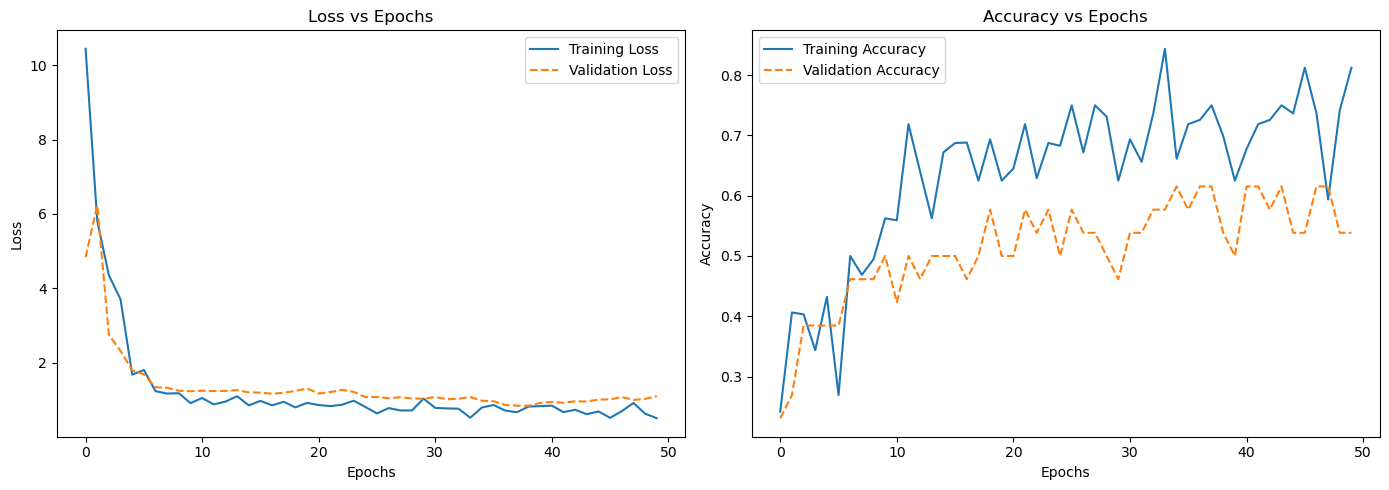

In [11]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
# It contains 'history.history' which stores metrics like loss and accuracy

# Step 1: Extract loss and accuracy values from the history
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']  # Validation loss
val_accuracy = history.history['val_accuracy']  # Validation accuracy

# Step 2: Create subplots to plot the graphs side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss vs Epochs
ax1.plot(loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss', linestyle='--')
ax1.set_title('Loss vs Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot Accuracy vs Epochs
ax2.plot(accuracy, label='Training Accuracy')
ax2.plot(val_accuracy, label='Validation Accuracy', linestyle='--')
ax2.set_title('Accuracy vs Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Paths to your datasets (update these paths accordingly)
train_data_path = '/home/batch25/Desktop/train_data2'
val_data_path = '/home/batch25/Desktop/val_data2'
test_data_path = '/home/batch25/Desktop/test_data2'

# Data Preprocessing with enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]  # Add brightness range
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[-50:]:  # Unfreeze last 50 layers
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),  # Add dropout to prevent overfitting
    layers.Dense(5, activation='softmax')  # Output layer with 5 classes
])

# Compile the model with a lower learning rate for fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Set up callbacks for learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_acc}")

# Predict on the test data
test_predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
test_predictions = np.argmax(test_predictions, axis=1)

# Get the true labels
true_labels = test_generator.classes

# Print classification metrics
print(classification_report(true_labels, test_predictions, target_names=test_generator.class_indices.keys()))


Found 218 images belonging to 5 classes.
Found 26 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 23,871,653 (91.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

/home/batch25/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.1702 - loss: 1.9446 - val_accuracy: 0.2692 - val_loss: 2.4412 - learning_rate: 1.0000e-04
Epoch 2/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - accuracy: 0.2500 - loss: 1.7724

/home/batch25/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 603ms/step - accuracy: 0.2500 - loss: 1.7724 - val_accuracy: 0.2692 - val_loss: 2.3766 - learning_rate: 1.0000e-04
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.2896 - loss: 1.6805 - val_accuracy: 0.1538 - val_loss: 2.1887 - learning_rate: 1.0000e-04
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 604ms/step - accuracy: 0.1875 - loss: 1.7706 - val_accuracy: 0.2308 - val_loss: 2.2623 - learning_rate: 1.0000e-04
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.3818 - loss: 1.5065 - val_accuracy: 0.3462 - val_loss: 2.2336 - learning_rate: 1.0000e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 597ms/step - accuracy: 0.3125 - loss: 1.6030 - val_accuracy: 0.3462 - val_loss: 2.1590 - learning_rate: 1.0000e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.4275 - loss: 1.4471 - val_accuracy: 0.3077 - val_loss: 2.0071 - learning_rate: 1.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 611ms/step - accuracy: 0.2812 - loss: 1.5999 - val_acc

/home/batch25/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/batch25/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/batch25/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Paths to your datasets (update these paths accordingly)
train_data_path = '/home/batch25/Desktop/train_data2'
val_data_path = '/home/batch25/Desktop/val_data2'
test_data_path = '/home/batch25/Desktop/test_data2'

# Data Preprocessing with enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],  # Add brightness range
    channel_shift_range=20.0,  # Add channel shift to augment color variations
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(224, 224),  # Increased image size for better feature extraction
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze more layers of the base model
for layer in base_model.layers[-100:]:  # Unfreeze last 100 layers
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(5, activation='softmax')  # Output layer with 5 classes
])

# Compile the model with a higher learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Set up callbacks for learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,  # Fewer epochs to prevent overfitting
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_acc}")

# Predict on the test data
test_predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
test_predictions = np.argmax(test_predictions, axis=1)

# Get the true labels
true_labels = test_generator.classes

# Print classification metrics
print(classification_report(true_labels, test_predictions, target_names=test_generator.class_indices.keys()))


Found 218 images belonging to 5 classes.
Found 26 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 23,871,653 (91.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

/home/batch25/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.2791 - loss: 1.8812 - val_accuracy: 0.2308 - val_loss: 1.5444 - learning_rate: 5.0000e-04
Epoch 2/30
1/6 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3438 - loss: 1.4157

/home/batch25/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 638ms/step - accuracy: 0.3438 - loss: 1.4157 - val_accuracy: 0.3462 - val_loss: 1.7426 - learning_rate: 5.0000e-04
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.6068 - loss: 0.9932 - val_accuracy: 0.3846 - val_loss: 2.1993 - learning_rate: 5.0000e-04
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 622ms/step - accuracy: 0.5625 - loss: 0.7857 - val_accuracy: 0.3846 - val_loss: 2.5178 - learning_rate: 5.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5667 - loss: 1.1667
Test Accuracy: 0.5666666626930237


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
              precision    recall  f1-score   support

           1       0.57      0.67      0.62         6
          10       1.00      0.17      0.29         6
          12       0.80      0.67      0.73         6
          20       1.00      0.50      0.67         6
           5       0.36      0.83      0.50         6

    accuracy                           0.57        30
   macro avg       0.75      0.57      0.56        30
weighted avg       0.75      0.57      0.56        30



In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
import numpy as np

# Paths to your datasets (update these paths accordingly)
train_data_path = '/home/batch25/Desktop/train_data2'
val_data_path = '/home/batch25/Desktop/val_data2'
test_data_path = '/home/batch25/Desktop/test_data2'

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(5, activation='softmax')  # Output layer with 5 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Callbacks to improve training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Ensure proper steps per epoch
    epochs=30,  # You can adjust this number as per your data
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,  # Ensure proper validation steps
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_acc}")

# Predict on the test data
test_predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
test_predictions = np.argmax(test_predictions, axis=1)

# Get the true labels
true_labels = test_generator.classes

# Print classification metrics
print(classification_report(true_labels, test_predictions, target_names=test_generator.class_indices.keys()))


Found 218 images belonging to 5 classes.
Found 26 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

/home/batch25/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.2116 - loss: 9.7237 - val_accuracy: 0.2692 - val_loss: 8.1939 - learning_rate: 0.0010
Epoch 2/30
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2500 - loss: 10.8613

/home/batch25/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step - accuracy: 0.2500 - loss: 10.8613 - val_accuracy: 0.3846 - val_loss: 4.8012 - learning_rate: 0.0010
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.3666 - loss: 3.6304 - val_accuracy: 0.1923 - val_loss: 2.5801 - learning_rate: 0.0010
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 597ms/step - accuracy: 0.1562 - loss: 2.7543 - val_accuracy: 0.2308 - val_loss: 2.1124 - learning_rate: 0.0010
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.3388 - loss: 1.9972 - val_accuracy: 0.4615 - val_loss: 1.4680 - learning_rate: 0.0010
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 600ms/step - accuracy: 0.4062 - loss: 1.8923 - val_accuracy: 0.3846 - val_loss: 1.4827 - learning_rate: 0.0010
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.3545 - loss: 1.5253 - val_accuracy: 0.4615 - val_loss: 1.2031 - learning_rate: 0.0010
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step - accuracy: 0.4231 - loss: 1.4138 - val_accuracy: 0.5000 - val_los

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

           1       1.00      0.17      0.29         6
          10       0.44      0.67      0.53         6
          12       0.60      0.50      0.55         6
          20       0.67      0.67      0.67         6
           5       0.44      0.67      0.53         6

    accuracy                           0.53        30
   macro avg       0.63      0.53      0.51        30
weighted avg       0.63      0.53      0.51        30

